In [1]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib


In [2]:
# get files & parsers

dir='/Volumes/Samsung_T5/NHMFL/2023_January_Christian/wastewater/Zorbax_5um_inject_1500ms/neg/subset'
flist=os.listdir(dir)
os.chdir(dir)

# get parsers

MSfiles={}

for f in flist:
    if ('.raw' in f) & ('._' not in f) & ('qh2o' not in f):
        print(f)
        parser = rawFileReader.ImportMassSpectraThermoMSFileReader(f)
        MSfiles[f]={'parser': parser}

data = icrms.lc_icr_assign(dir)

data.master_data_holder = MSfiles

data._raw_filelist = data.master_data_holder.keys()

20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_300_500_02.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_NovWastewater_fullmz_01.raw


In [5]:
# set assignment parameters
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,3)
MSParameters.molecular_search.usedAtoms['I'] = (0,1)
MSParameters.molecular_search.usedAtoms['F'] = (0,1)
MSParameters.molecular_search.usedAtoms['Cl'] = (0,1)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)


In [ ]:
# run assignment algorithm
timerange = [6,20]  # start (min) to stop (min)
interval = 2  # min 
refmasslist = "/Users/christiandewey/CoreMS/db/Hawkes_neg.ref"

data.assign_formula(interval = interval, timerange = timerange, 
    refmasslist = refmasslist, calorder =2, charge = 1, cal_ppm_threshold= (0,3))
#data_df = lcmsfns.assign_formula(parser=parser, interval = interval, timerange = timerange, refmasslist = refmasslist, calorder =2, charge = -1)

data_df = data.complete_results_df

In [7]:
# save assignment results as pd dataframe and export as .csv 
fname = 'ww_initial_assignment.csv'
data_df.to_csv(dir+'/' +fname)


In [8]:

# add 'm/z window' and 'rep' columns
# reload modules & set fname
importlib.reload(icrms)
importlib.reload(lcmsfns)

data_df = pd.read_csv(dir+'/' +fname)
data_df = lcmsfns.add_mzwindow_col(data_df)

data_df = lcmsfns.addRepCol(data_df)

print(data_df['m/z window'].unique())
print(data_df['Rep'].unique())
print(data_df['file'].unique())
print(data_df['m/z Window Size'].unique())

20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw
20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw
[1]
['300-500 m/z' '200-1200 m/z']
[1]
['20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_300_500_01.raw'
 '20230113_LBA_Boiteau_Zorbax5um_1500IT_neg_FinalEff_fullmz_01.raw']
['200 m/z' '1000 m/z']


In [41]:
importlib.reload(icrms)
importlib.reload(lcmsfns)

heter = ['N', 'S']
molclasses = lcmsfns.get_mol_class(heter)

molclasses

['CHO', 'CHON', 'CHONS', 'CHOS', 'Unassigned']

In [ ]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
data_df = lcmsfns.assign_mol_class(data_df,molclasses)

In [11]:
# add column with blank file identity to use in blank subtraction

raw_filelist = data_df['file'].unique()

blank_files = [f for f in raw_filelist if 'qh2o' in f]

blank_data = []

for f in blank_files:

    #if 'fullmz' not in f:
        
    temp = data_df[data_df['file'] == f] 

    blank_data.append(temp)

blanks_df = pd.concat(blank_data)  # these are only 100 m/z blanks (200 m/z blanks were not collected)


print(blanks_df['file'].unique())

print(blanks_df['m/z window'].unique())


data_df['blank file'] = data_df.index

for window in data_df['m/z window'].unique():

    temp1 = data_df[data_df['m/z window'] == window] # all features collected in given m/z window       
    btemp1 = blanks_df[blanks_df['m/z window'] == window] # all blank feautres collected in same m/z window
    for r in temp1['Rep'].unique():
        temp2 = temp1[temp1['Rep'] == r]
        btemp2 = btemp1[btemp1['Rep'] == r]

     #  print(np.shape( btemp2['file']))

        temp2['blank file'] = btemp2['file'].iloc[0]
     #   print(np.shape( btemp2['file']))
        data_df[(data_df['m/z window'] == window) & (data_df['Rep'] == r)]  = temp2




ValueError: No objects to concatenate

In [ ]:
# save assignment results as pd dataframe and export as .csv 
data_df.to_csv(dir+'/processed_'+fname)


In [4]:
#-#-#-# read assignment results from .csv
dir = '/Volumes/Samsung_T5/NHMFL/2023_January_Christian/wastewater/Zorbax_5um_inject_1500ms/neg/'
fname = 'processed_ww_initial_assignment.csv'
data_df = pd.read_csv(dir+fname)

In [5]:
# create subsets of assignments based m/z window

list100mz = []
listfullzmz = [] 

for mzwindow in data_df['m/z window'].unique():

    r_df = data_df[data_df['m/z window'] == mzwindow]

    if (mzwindow == '300-500 m/z') :
        list100mz.append(r_df) 

    elif (mzwindow == '200-1200 m/z'):
        listfullzmz.append(r_df) 

mz100 = pd.concat(list100mz)
mzfull = pd.concat(listfullzmz)


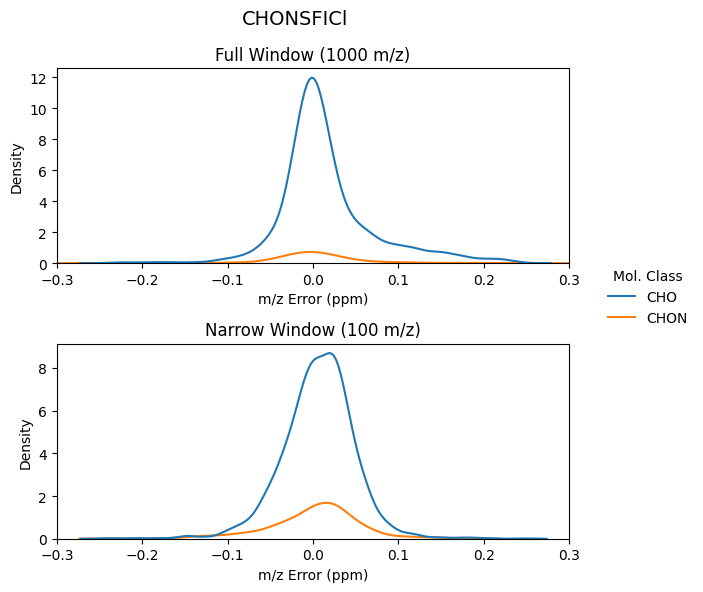

In [44]:
# plot assignment error kernel density CHON

ttt = 'CHONSFICl'  ## title for main plot

dffull = mzfull[(mzfull['mol_class']=='CHO') | (mzfull['mol_class']=='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

df100 = mz100[(mz100['mol_class']=='CHO') | (mz100['mol_class']=='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)


fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


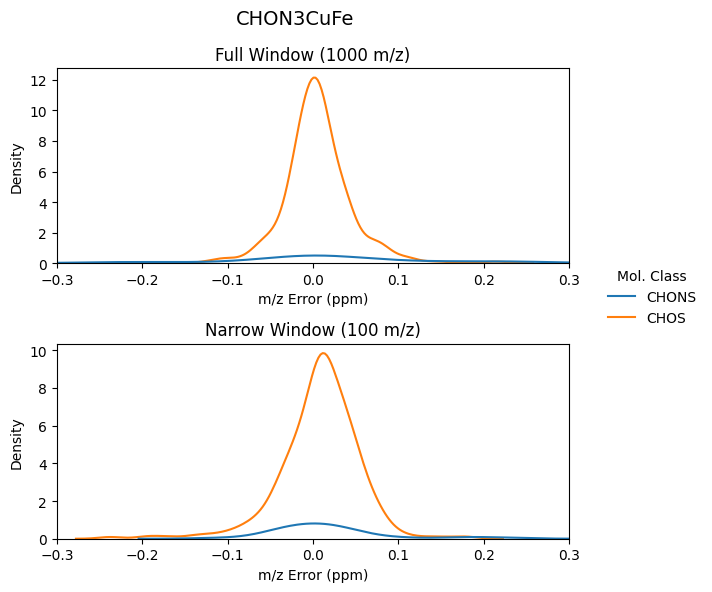

In [45]:
# plot assignment error kernel density CHON
import itertools
ttt = 'CHON3CuFe'  ## title for main plot

# set palette 
palette = itertools.cycle(sns.color_palette())



dffull = mzfull[(mzfull['mol_class']!='CHO') & (mzfull['mol_class']!='CHON')]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,6))
sns.kdeplot(data=dffull[dffull['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax1, palette=palette)
ax1.set_xlim(-0.3,0.3)
ax1.set_title( 'Full Window (1000 m/z)')
legend = ax1.get_legend()
handles = legend.legendHandles
labels = dffull[dffull['mol_class']!='Unassigned']['mol_class'].unique()
legend.remove()

palette = itertools.cycle(sns.color_palette())

df100 = mz100[(mz100['mol_class']!='CHO') & (mz100['mol_class']!='CHON')]
sns.kdeplot(data=df100[df100['mol_class']!='Unassigned'], x="m/z Error (ppm)", hue="mol_class", ax = ax2, legend = False, palette=palette)
ax2.set_title( 'Narrow Window (100 m/z)')
ax2.set_xlim(-0.3,0.3)

fig.suptitle(ttt, fontsize=14)
fig.legend(handles, labels, title='Mol. Class', frameon = False, bbox_to_anchor=(1.0,0.5), loc = 'center left')

plt.tight_layout()

plt.show()


In [6]:
# create subsets of assigned features 
assigned_100mz = mz100[~mz100['Molecular Formula'].isnull()]
assigned_fullmz = mzfull[~mzfull['Molecular Formula'].isnull()]

print('400-700 m/z, 100 m/z windowing: \n%s features total; %s assigned (%.1f%%)' %(np.shape(mz100)[0],  np.shape(assigned_100mz)[0], np.shape(assigned_100mz)[0] / np.shape(mz100)[0] * 100))
print('\n200-800 m/z window (full scan): \n%s features total; %s assigned (%.1f%%)' %(np.shape(mzfull)[0],np.shape(assigned_fullmz)[0],  np.shape(assigned_fullmz)[0] / np.shape(mzfull)[0] * 100))

400-700 m/z, 100 m/z windowing: 
32095 features total; 28733 assigned (89.5%)

200-800 m/z window (full scan): 
28928 features total; 25112 assigned (86.8%)


In [7]:
# create subsets of unique features 
print('400-700 m/z, 100 m/z windowing:')
unique_100mz = lcmsfns.getUniqueFeatures(assigned_100mz)

print('\n200-800 m/z, 1000 m/z windowing:')
unique_fullmz = lcmsfns.getUniqueFeatures(assigned_fullmz)


400-700 m/z, 100 m/z windowing:

200-800 m/z, 1000 m/z windowing:


In [8]:
# subset assigned by m/z window between 400 and 700 m/z 
assigned_100mz_456 = assigned_100mz[(assigned_100mz['m/z']>=300)]
assigned_100mz_456 = assigned_100mz_456[(assigned_100mz_456['m/z']<=500)]

assigned_fullmz_456 = assigned_fullmz[(assigned_fullmz['m/z']>=300)]
assigned_fullmz_456 = assigned_fullmz_456[(assigned_fullmz_456['m/z']<=500)]

mz100_456 = mz100[(mz100['m/z']>=300)]
mz100_456 = mz100_456[(mz100_456['m/z']<=500)]

mzfull_456 = mzfull[(mzfull['m/z']>=300)]
mzfull_456 = mzfull_456[(mzfull_456['m/z']<=500)]

print('400-700 m/z, 100 m/z windowing: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mz100_456)[0],  np.shape(assigned_100mz_456)[0], np.shape(assigned_100mz_456)[0] / np.shape(mz100_456)[0] * 100))
print('\n400-700 m/z, full window: \n%s features total\n%s assigned (%.1f%%)' %(np.shape(mzfull_456)[0],np.shape(assigned_fullmz_456)[0],  np.shape(assigned_fullmz_456)[0] / np.shape(mzfull_456)[0] * 100))


400-700 m/z, 100 m/z windowing: 
32095 features total
28733 assigned (89.5%)

400-700 m/z, full window: 
17288 features total
15717 assigned (90.9%)


In [9]:
print('400-700 m/z, 100 m/z windowing:')
unique_100mz_456 = lcmsfns.getUniqueFeatures(assigned_100mz_456)

print('\n400-700 m/z, 1000 m/z windowing:')
unique_fullmz_456 = lcmsfns.getUniqueFeatures(assigned_fullmz_456)

400-700 m/z, 100 m/z windowing:

400-700 m/z, 1000 m/z windowing:


In [10]:
import matplotlib.gridspec as gridspec

mz100_bs = unique_100mz_456# lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = unique_fullmz_456 #lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=300) & (mzfull_bs['Calibrated m/z']<=500)]
combo = pd.concat([mz100_bs, mzfull_bs_456], ignore_index=True)


for i in range(len(combo['m/z window'])):

    w = combo['m/z window'].iloc[i]

    if (w == '300-500 m/z') :
        
        combo['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo['m/z Window Size'].iloc[i] = '1000 m/z'

print(combo['m/z Window Size'].unique())


mzfull_456 = mzfull[(mzfull['Calibrated m/z']>=300) & (mzfull['Calibrated m/z']<=500)]
combo2 = pd.concat([mz100, mzfull_456], ignore_index=True)

for i in range(len(combo['m/z window'])):

    w = combo2['m/z window'].iloc[i]

    if (w == '300-500 m/z') :
        
        combo2['m/z Window Size'].iloc[i] = '200 m/z'

    elif (w == '200-1200 m/z'):
        
        combo2['m/z Window Size'].iloc[i] = '1000 m/z'

print(np.shape(combo),np.shape(combo2))


['200 m/z' '1000 m/z']
(13850, 54) (49383, 41)


In [76]:
fullscan = combo[combo['m/z Window Size'] == '1000 m/z']
narrowscan = combo[combo['m/z Window Size'] == '200 m/z']

narrow_only = narrowscan[~narrowscan['Molecular Formula'].isin(fullscan['Molecular Formula'])]

full_only = fullscan[~fullscan['Molecular Formula'].isin(narrowscan['Molecular Formula'])]

narrow_full = narrowscan[narrowscan['Molecular Formula'].isin(fullscan['Molecular Formula'])]

print('MFs in narrow window only: %s' %len(narrow_only))
print('MFs in full window only: %s' %len(full_only))
print('MFs in narrow and full window only: %s' %len(narrow_full))

combo_adj = combo 

combo_adj['FeatureIn'] = combo_adj.index

holder = []

naronly = narrow_only['Molecular Formula'].isin(combo_adj['Molecular Formula'])

sub = combo_adj.loc[naronly.index]

sub['FeatureIn'] = '200 m/z only'

print(len(sub))
holder.append(sub)


both = narrow_full['Molecular Formula'].isin(combo_adj['Molecular Formula'])

sub1 = combo_adj.loc[both.index]

sub1['FeatureIn'] = 'Both windows'

holder.append(sub1)

df = pd.concat(holder)

#combo_adj['FeatureIn'] = test.index

MFs in narrow window only: 2280
MFs in full window only: 165
MFs in narrow and full window only: 6528
2280


In [15]:
test = df
test['S/C'] = test['S']/test['C']

test = test[test['S/C']>0]

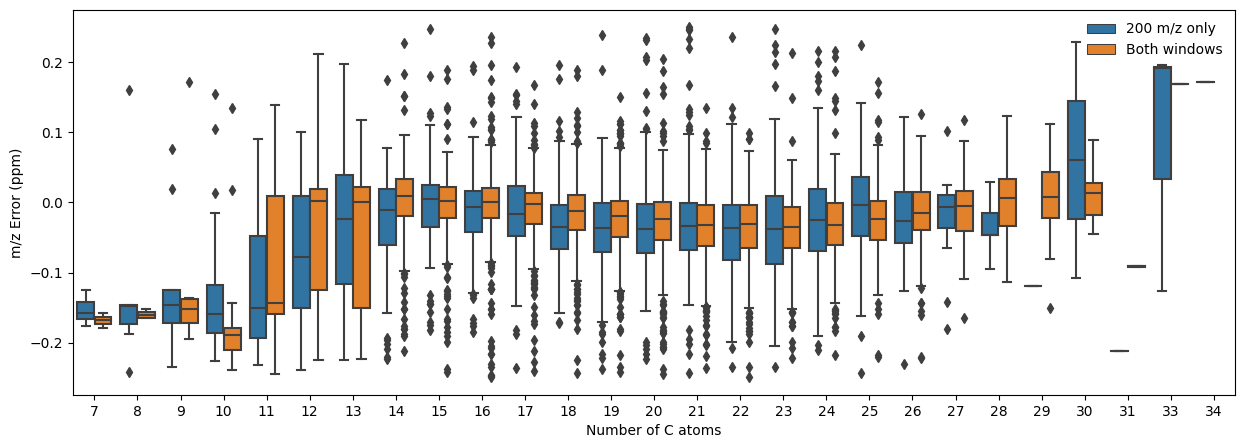

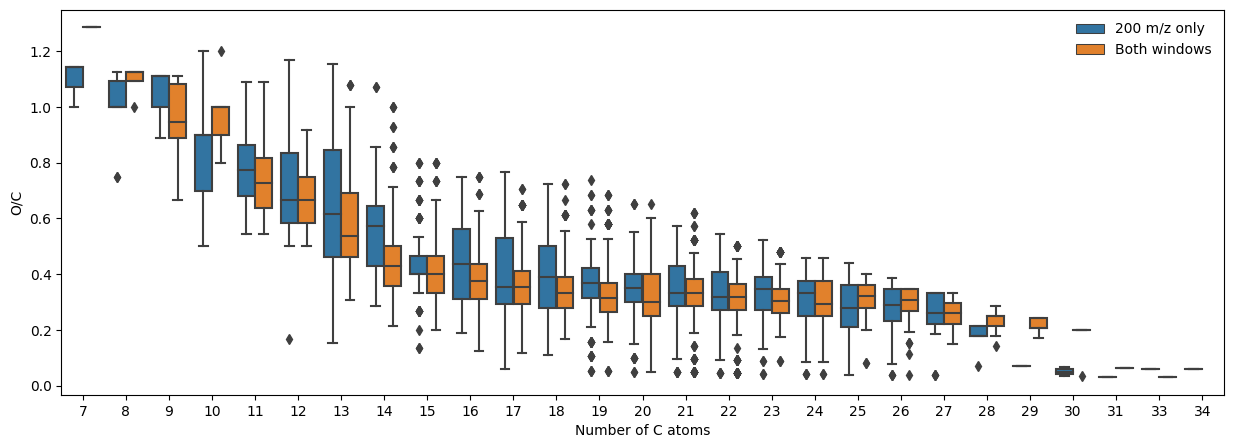

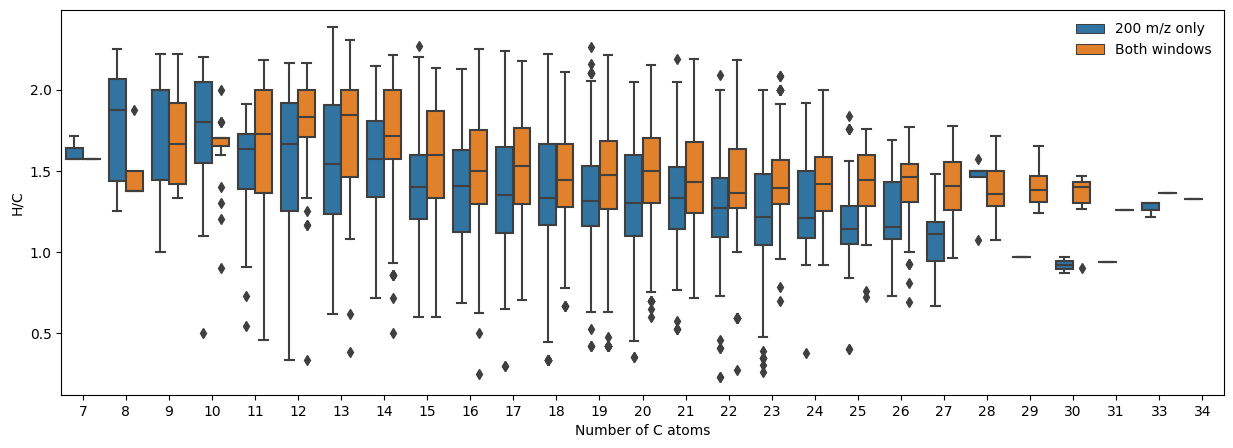

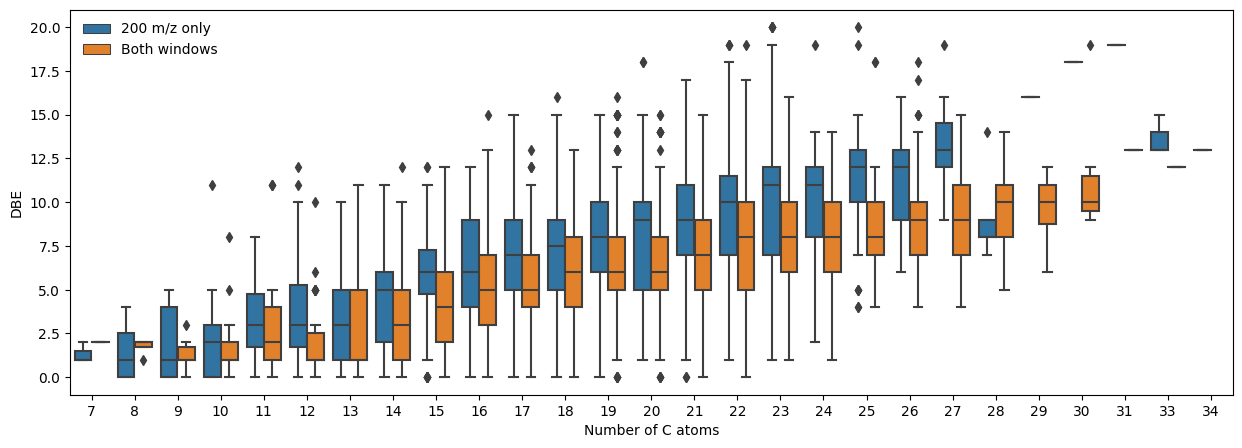

In [26]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'm/z Error (ppm)', hue = 'FeatureIn',showfliers = True )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')

plt.show()

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'O/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'H/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'DBE', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()



In [ ]:


fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'N/C', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()




fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'Confidence Score', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()


fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'm/z', hue = 'FeatureIn' )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')
plt.show()



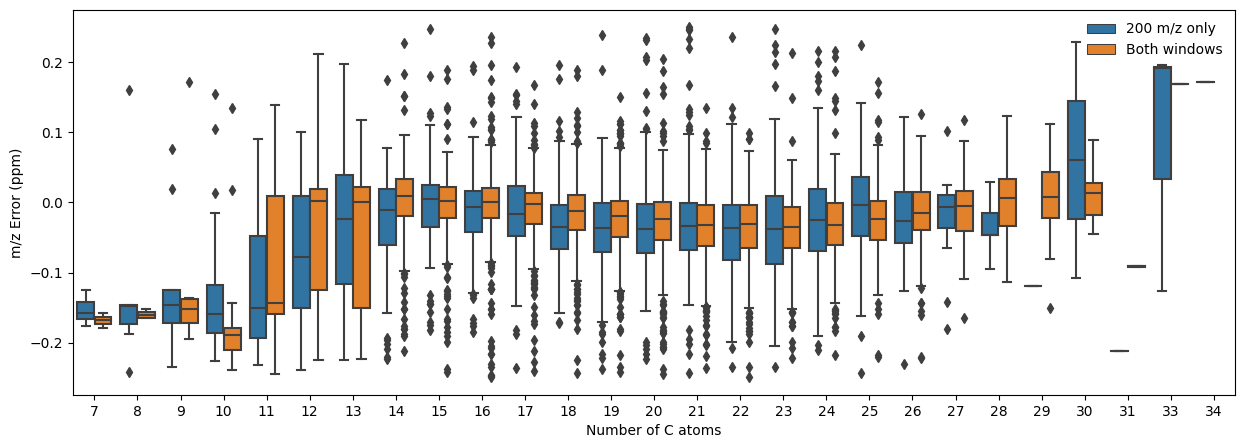

In [13]:
fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df, x = 'C' , y = 'm/z Error (ppm)', hue = 'FeatureIn',showfliers = True )
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')

plt.show()

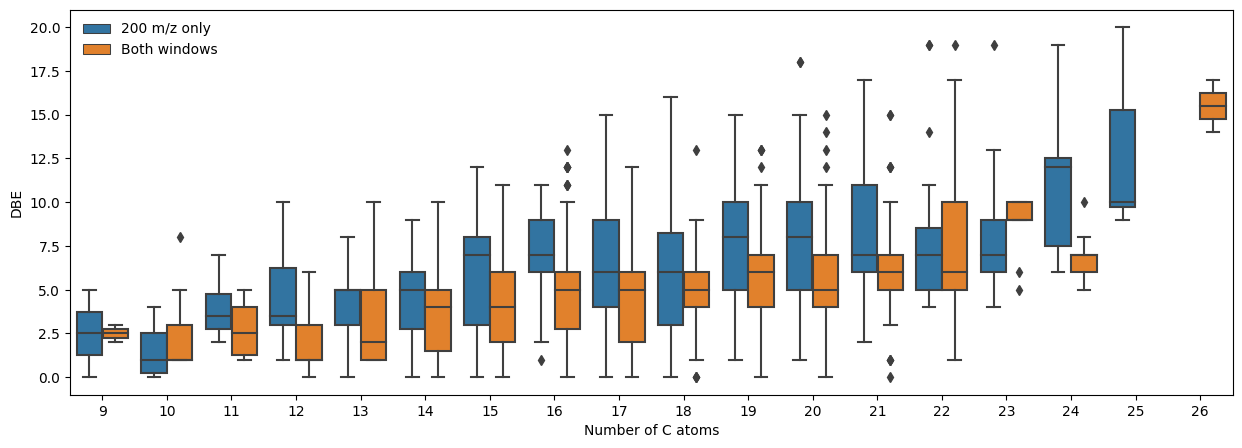

In [61]:
df_sub = df[(df['S']>0) & (df['C']<28) & (df['C']>8)]

fig,ax = plt.subplots(figsize = (15,5))
ax = sns.boxplot(data = df_sub, x = 'C' , y = 'DBE', hue = 'FeatureIn',showfliers = True )
#ax = sns.violinplot(data = df_sub, x = 'C' , y = 'DBE', hue = 'FeatureIn',split=True)
labels = ax.get_xticklabels()
lbls = [int(c.get_text().split('.')[0]) for c in labels]
ax.set_xticklabels(lbls)
ax.legend(frameon = False)
ax.set_xlabel('Number of C atoms')

plt.show()


In [65]:
import time as time

from sklearn.cluster import AgglomerativeClustering

print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 2  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward",affinity='euclidean')

ward.fit_predict()


print(f"Elapsed time: {time.time() - st:.3f}s")
print(f"Number of pixels: {label.size}")
print(f"Number of clusters: {np.unique(label).size}")

In [80]:
#df_sub = df[['C','H','O','N','m/z Window Size']]
        #Generate clusters of ms features across depth.
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize


#clustermethod='average'
clustermethod='ward'
dfa = df
abundances=dfa[]


KeyError: "None of [Index(['200 m/z'], dtype='object')] are in the [columns]"

In [92]:
#clustermethod='average'
clustermethod='ward'
dfa = df[(~df['file'].str.contains("qh2o"))&(~df['file'].str.contains("Nov"))]

abundances=dfa[dfa['file'].unique()].fillna(0)
df1=abundances.mean(axis=1)
df_std=abundances.std(axis=1)

p_list=[]
for ind in abundances.index:
    p=max(abs(abundances.loc[ind]-df1[ind]))/df_std[ind]
    if len(abundances.loc[ind][abundances.loc[ind]>1])<2:
        p=0
    p_list.append(p)

#abundances['p']=p_list
#abundances=abundances[abundances['p']>0.1]
#abundances=abundances.sort_values(by='p',ascending=False)


In [93]:

dfa['p']=p_list

#plt.hist(p_list,bins=100,range=[min(p_list),max(p_list)])

results_clustered=dfa[dfa['p']>0.1]
norm_abundances=results_clustered[dfa['file'].unique()].fillna(0)
norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)

lut = dict(zip(species.unique(), "rbg"))
row_colors = species.map(lut)

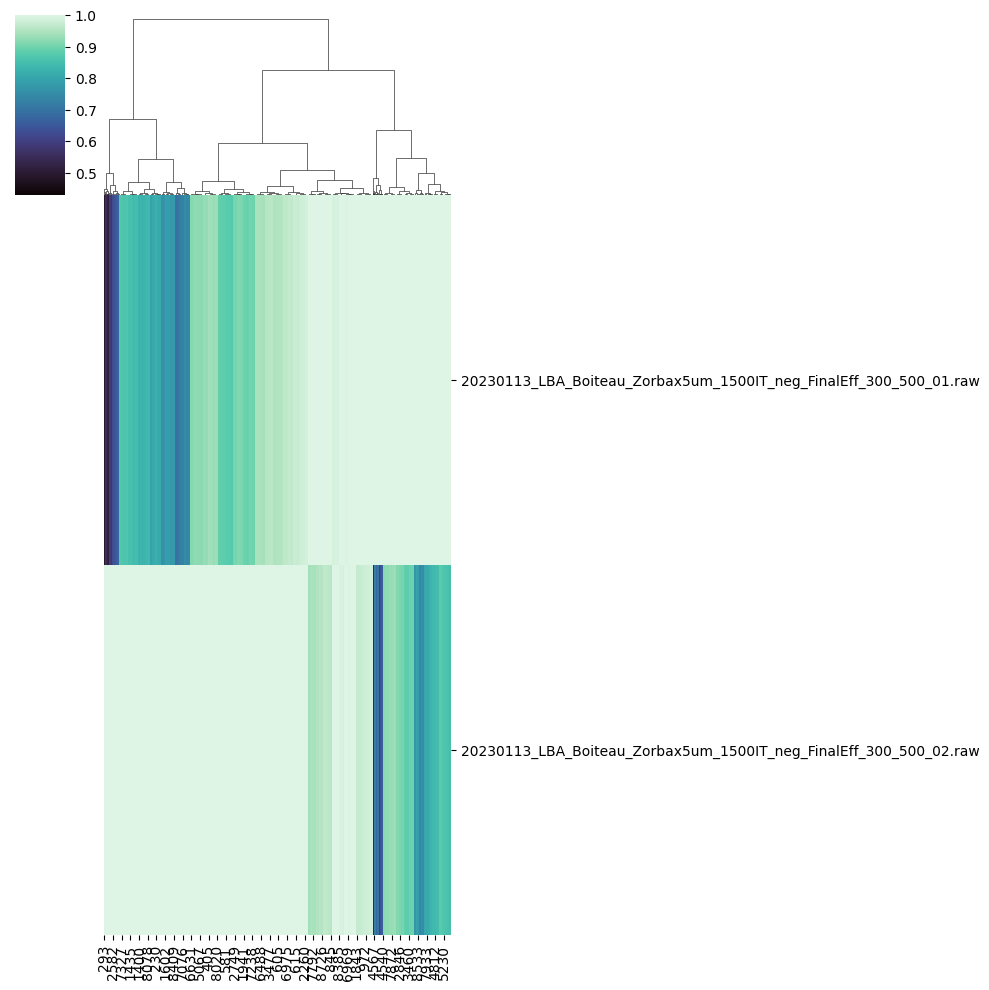

In [94]:

cluster = AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage=clustermethod)
cluster.fit_predict(norm_abundances)

results_clustered['cluster']=cluster.labels_

#results_clustered.fillna(0).to_csv(file_location+'clustered_results.csv')

clusterplot=norm_abundances
#clusterplot=clusterplot.drop(['p'],axis=1)
clusterplot=clusterplot.transpose()

#clusterplot=clusterplot.sort_values(by='sort_order')
#clusterplot=clusterplot.drop(['sort_order'],axis=1)

# fig, ax = plt.subplots()

p1 = sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

fig = plt.gcf()


plt.show()


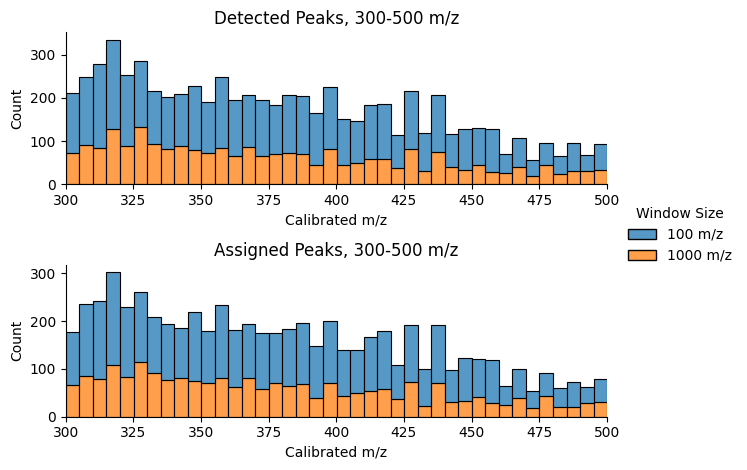

In [51]:

import matplotlib.gridspec as gridspec

#fig, (ax1_t,ax1_b, ax2) = plt.subplots(nrows=3, ncols=1, sharex = True, gridspec_kw={'hspace':0.02})
plt.subplots_adjust(hspace=0.3)
#make outer gridspec
outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
#make nested gridspecs
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])


ax1 = plt.subplot(gs2[0])

sns.histplot(combo, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax1,binwidth=5)
ax1.set_ylabel('Count')
ax1.legend_.remove()
ax1.set_xlim(300,500)
ax1.set_title('Assigned Peaks, 300-500 m/z')
#ax1.set_ylim(0,4500)

sns.despine(ax=ax1)


ax2 = plt.subplot(gs1[0])

sns.despine(ax=ax2)

sns.histplot(combo2, x="Calibrated m/z", hue="m/z Window Size", multiple="stack", ax=ax2,binwidth=5)
ax2.set_ylabel('Count')
ax2.set_xlim(300,500)
#ax2.set_ylim(0,4500)
ax2.set_title('Detected Peaks, 300-500 m/z')
legend = ax2.get_legend()
handles = legend.legendHandles
labels = ['100 m/z','1000 m/z']
ax2.legend_.remove()

fig = plt.gcf()

fig.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size')

fig.tight_layout()
plt.show()

['CHO' 'CHON' 'CHONS' 'CHOS' 'Unassigned']


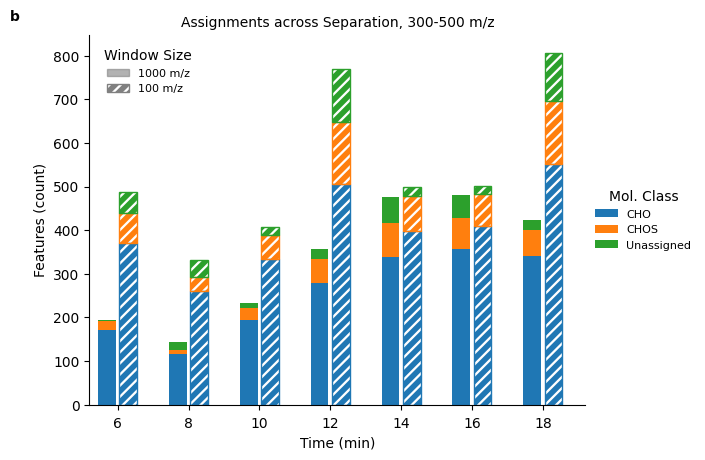

In [56]:
import matplotlib.patches as mpatches
fig, ax4 = plt.subplots()

all_results = pd.concat([mzfull[(mzfull['m/z']>=300) & (mzfull['m/z']<=500)],mz100[(mz100['m/z']>=300) & (mz100['m/z']<=500)]], ignore_index=True)

print(all_results['mol_class'].unique())
assign_summary=[]
for time in all_results['Time'].unique():    
    for w in all_results['m/z Window Size'].unique():
        current={}
        current['Time']=time
        current['m/z Window'] = w
        for mol_class in ['CHO','CHOS', 'Unassigned']:
            current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['m/z Window Size']==w)])
        assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df100 = df[df['m/z Window']=='100 m/z']

ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
#ax4 = df100.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4)
plt.rcParams['hatch.linewidth'] = 4
n = 14
for i in range(n):
    new_x = ax4.patches[i].get_x() - ((i%2)/2)
    ax4.patches[i].set_x(new_x)
    ax4.patches[i+n].set_x(new_x)
    ax4.patches[i+(2*n)].set_x(new_x)

    if (i%2)/2 > 0:
        ax4.patches[i].set_x(new_x+0.1)
        ax4.patches[i+n].set_x(new_x+0.1)
        ax4.patches[i+(2*n)].set_x(new_x+0.1)

        ax4.patches[i].set_hatch('///')
        ax4.patches[i].set_edgecolor('C0')
        ax4.patches[i].set_fill(None)
        #ax4.patches[i].set_alpha(0.7)
        ax4.patches[i+n].set_hatch('///')
        ax4.patches[i+n].set_edgecolor('C1')
        ax4.patches[i+n].set_fill(None)
        #ax4.patches[i+(2*n)].set_alpha(0.7)
        ax4.patches[i+(2*n)].set_hatch('///')
        ax4.patches[i+(2*n)].set_edgecolor('C2')
        ax4.patches[i+(2*n)].set_fill(None)



# Update tick locations correspondingly
#minor_tick_locs = [x.get_x()+1/4 for x in ax4.patches[:28]]
major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:14]]).reshape(7, 2).mean(axis=1)
#ax4.set_xticks(minor_tick_locs, minor=True)
ax4.set_xticks(major_tick_locs)

# Use indices from dataframe as tick labels
major_tick_labels = df['Time'].unique()
#major_tick_labels = df_g.index.levels[0].values
#ax4.xaxis.set_ticklabels(minor_tick_labels, minor=True)
ax4.xaxis.set_ticklabels(major_tick_labels)

# Remove ticks and organize tick labels to avoid overlap
#ax4.tick_params(axis='x', which='both', bottom='off')
#ax4.tick_params(axis='x', which='minor', rotation=45)
ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

ax4.set_xlabel('Time (min)')
ax4.set_ylabel('Features (count)')

leg = plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), frameon=False, title='Mol. Class', prop={'size': 8})
ax4.add_artist(leg)
ax4.set_title('Assignments across Separation, 300-500 m/z',fontsize= 10)
a_val = 0.6

patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
patch_100 = mpatches.Patch(edgecolor='gray', facecolor = 'white', hatch = '///',label='100 m/z')



colors = ['#EA5739','#FEFFBE','#4BB05C']


#circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'\\\\',label='Label1')
#circ2= mpatches.Patch( facecolor=colors[1],alpha=a_val,hatch='o',label='Label2')
#circ3 = mpatches.Patch(facecolor=colors[2],alpha=a_val,hatch='+',label='Label3')


plt.legend(handles=[patch_full, patch_100], loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.


sns.despine(ax=ax4)
ax4.text(-.15, 1.05,'b',
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax4.transAxes, fontweight='bold', fontsize = 10)
sns.despine(ax=ax4)

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(666, 44) (350, 44)
here


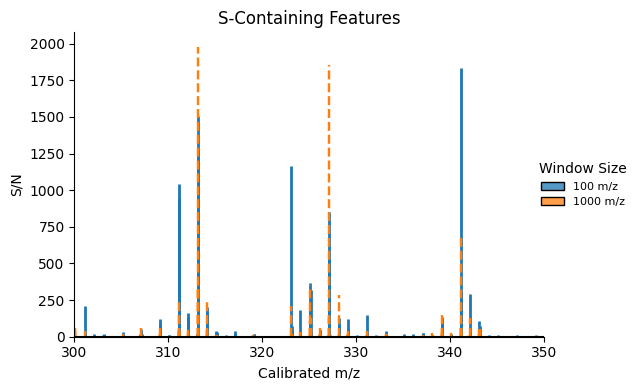

In [77]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec



fig, ax2 = plt.subplots(figsize = (6.5,4))

mz100_bs = unique_100mz_456 #lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = unique_fullmz_456 #lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=300) & (mzfull_bs['Calibrated m/z']<=500)]

mz100_cu = mz100_bs[(mz100_bs['Calibrated m/z']>=300) & (mz100_bs['Calibrated m/z']<=500) ]

d1=lcmsfns.normMS(mz100_cu[mz100_cu['S']>0],mz100_cu[mz100_cu['S']>0])
d2=lcmsfns.normMS(mzfull_bs_456[mzfull_bs_456['S']>0],mzfull_bs_456[mzfull_bs_456['S']>0])

#d1=mz100_bs[mz100_bs['Cu']>0]
#d2=mzfull_bs_456[mzfull_bs_456['Cu']>0]
print(np.shape(d1),  np.shape(d2))

ax2 = lcmsfns.plot_ms(df1=d1,  df2=d2, start_mz=300, end_mz=500,ax_ms=ax2, norm=False)

sns.despine(ax=ax2)

ax2.set_xlim(300,350)
ax2.set_ylim(bottom=0)
#ax2.set_title('S-Containing Features')
print('here')

ax2.legend(handles, labels, bbox_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})

plt.tight_layout()
plt.show()

In [75]:

res = mz100_cu.loc[~mz100_cu['Molecular Formula'].isin(mzfull_bs_456['Molecular Formula'])] 
fullonly  = mzfull_bs_456.loc[~mzfull_bs_456['Molecular Formula'].isin(mz100_cu['Molecular Formula'])] 

print(np.shape(res),np.shape(mz100_cu), np.shape(mzfull_bs_456),  np.shape(fullonly))

(1156, 43) (4092, 43) (2298, 43) (27, 43)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(225, 44) (350, 44)
here


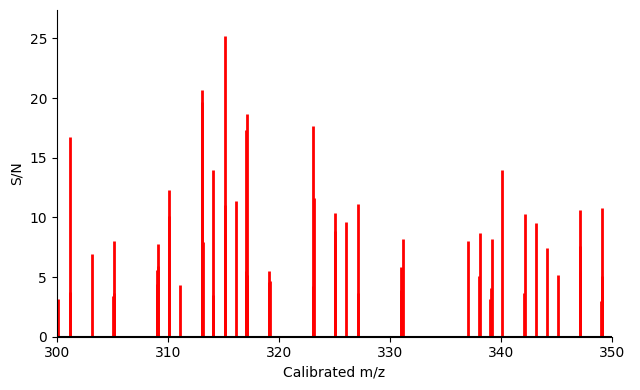

In [74]:
importlib.reload(icrms)
importlib.reload(lcmsfns)
import matplotlib.gridspec as gridspec

res = mz100_cu.loc[~mz100_cu['Molecular Formula'].isin(mzfull_bs_456['Molecular Formula'])] 

#res = mzfull_bs_456.loc[~mzfull_bs_456['Molecular Formula'].isin(mz100_cu['Molecular Formula'])] 

fig, ax2 = plt.subplots(figsize = (6.5,4))

mz100_bs = unique_100mz_456 #lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
mzfull_bs = unique_fullmz_456 #lcmsfns.blankSubtract(unique_fullmz, blnkthresh = 0.6)

mzfull_bs_456 = mzfull_bs[(mzfull_bs['Calibrated m/z']>=300) & (mzfull_bs['Calibrated m/z']<=500)]

mz100_cu = mz100_bs[(mz100_bs['Calibrated m/z']>=300) & (mz100_bs['Calibrated m/z']<=500) ]

d1=lcmsfns.normMS(mz100_cu[mz100_cu['S']>0],mz100_cu[mz100_cu['S']>0])
d1=lcmsfns.normMS(res[res['S']>0],res[res['S']>0])

#d1=mz100_bs[mz100_bs['Cu']>0]
#d2=mzfull_bs_456[mzfull_bs_456['Cu']>0]
print(np.shape(d1),  np.shape(d2))

ax2 = lcmsfns.plot_ms(df1=d1,   start_mz=300, end_mz=500,ax_ms=ax2, norm=False, colors = ['red'])

sns.despine(ax=ax2)

ax2.set_xlim(300,350)
ax2.set_ylim(bottom=0)

print('here')

#ax2.legend(box_to_anchor=(0.98, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})

plt.tight_layout()
plt.show()

(4092, 43)
(4092, 43)
[0 1 2 3]


ValueError: The palette list has the wrong number of colors.

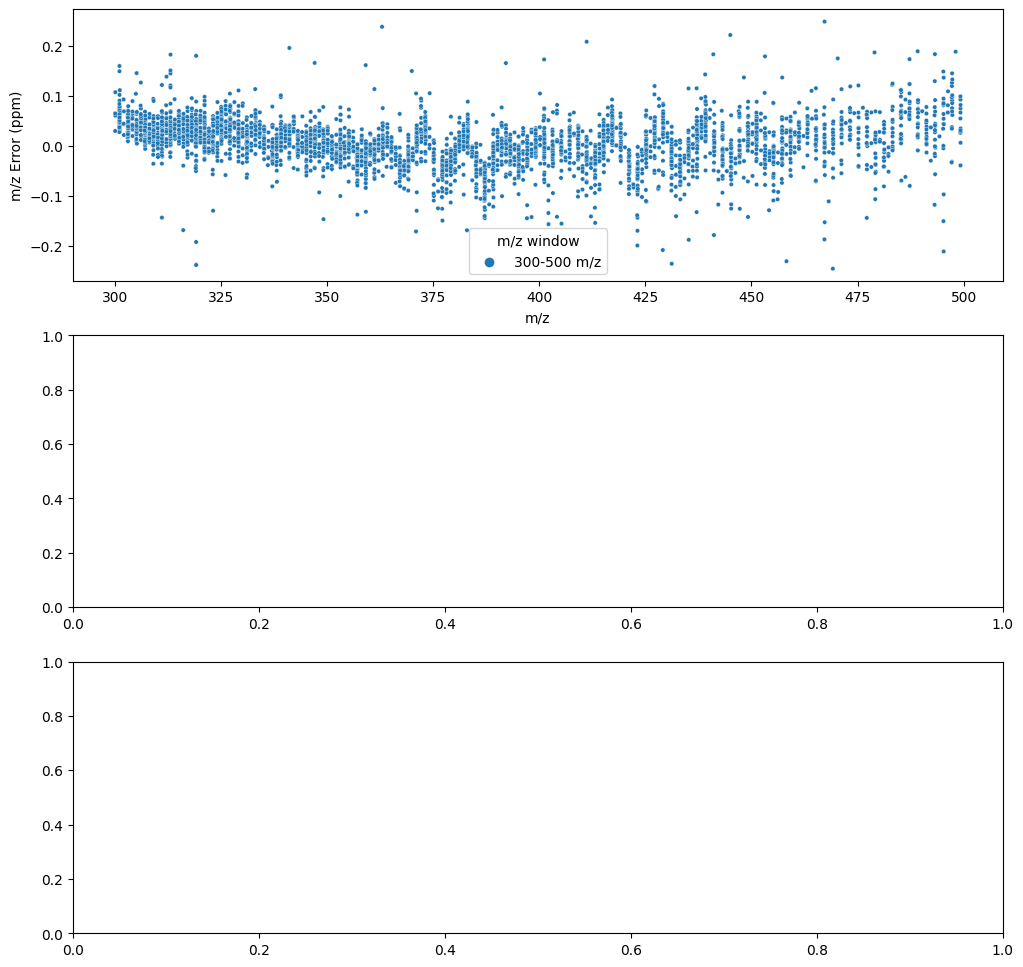

In [73]:
# 100 m/z window, error plots with blank substraction

importlib.reload(icrms)
importlib.reload(lcmsfns)
df = unique_100mz#lcmsfns.blankSubtract(unique_100mz, blnkthresh = 0.6)
print(np.shape(unique_100mz))
print(np.shape(df))
fig = lcmsfns.plotUnique(df,ps=10)

fig.suptitle('100 m/z window, '+ttt, fontsize=14)

fig.set_size_inches(8,9)
plt.tight_layout()

plt.show()